# Create perturbed FY files (only variance, all energies)

In [1]:
import sandy
import pandas as pd
from os.path import join
import numpy as np
import random, sys
import matplotlib.pyplot as plt

## Extract FYs and covariance data for U235 fission

In [2]:
za = 92235
tape = sandy.get_endf6_file("jeff_33", "nfpy", za * 10)
nfpy = sandy.Fy.from_endf6(tape)

## Generate perturbation coefficients for all energies and write them to file

In [10]:
energies = nfpy.data.E.unique()

In [12]:
nsmp = 100 # sample size
smp = {}
rcovs = {}
acovs = {}
for e in energies:
    idx = nfpy.data.query(f"E=={e} & MT==454").index
    ify = nfpy.data.loc[idx]
    relative_dfy = (ify.DFY/ify.FY).fillna(0).values
    cov = rcovs[e] = sandy.CategoryCov(np.diag(relative_dfy**2), index=ify.ZAP, columns=ify.ZAP)  # Diagonal covariance matrix
    acovs[e] = sandy.CategoryCov(np.diag(ify.DFY**2), index=ify.ZAP, columns=ify.ZAP)  # Diagonal covariance matrix
    seed = random.randrange(2**32 - 1)    # create a seed
    print(f"sampling IFY for energy {e:.3e} eV...")
    smp[e] = cov.sampling(nsmp, seed=seed)   # need to change the seed for the different energies    

sampling IFY for energy 2.530e-02 eV...
sampling IFY for energy 4.000e+05 eV...
sampling IFY for energy 1.400e+07 eV...


In [13]:
with pd.ExcelWriter(f'PERT_{za}_MF8_MT454.xlsx') as writer:
    for e, s in smp.items():
        s.data.to_excel(writer, sheet_name=f'{e:.3e}')

## Read coefficients from perturbation file and generate random FY ENDF-6 files

Skip the part above if you already have the file of perturbations.

In [14]:
smp = pd.read_excel(f'PERT_{za}_MF8_MT454.xlsx', sheet_name=None, index_col=0)

In [15]:
za = 92235
tape = sandy.get_endf6_file("jeff_33", "nfpy", za * 10)
nfpy = sandy.Fy.from_endf6(tape)

In [16]:
### run only if you want consistent CFYs
# tape_rdd = sandy.get_endf6_file("jeff_33", "decay", "all")
# rdd = sandy.DecayData.from_endf6(tape_rdd)  # this can take a while

In [17]:
smp_min = 0   # write ENDF-6 file only in the sample range [smp_min, smp_max]
smp_max = 99
file_template = "u235_fy_{}.jeff33"
for ismp in range(smp_min, smp_max+1):
    file = file_template.format(ismp)
    f = sandy.Fy(nfpy.data.copy())
    for e, s in smp.items():
        idx_ify = nfpy.data.query(f"E=={float(e)} & MT==454").index
        idx_cfy = nfpy.data.query(f"E=={float(e)} & MT==459").index
        f.data.loc[idx_ify, "DFY"] = f.data.loc[idx_ify, "FY"]            # just for me, i copy the original IFYs where uncertainties should be, so i can compare them to the perturbed ones (anyways I don't use uncertainties)
        f.data.loc[idx_cfy, "DFY"] = f.data.loc[idx_cfy, "FY"]            # same but for CFYs
        f.data.loc[idx_ify, "FY"] *= s[ismp].values                # IMPORTANT, this does not update the CFYs, which in random ENDF-6 file are inconsistent with the perturbed IFYs
        #f = f.apply_qmatrix(922350, e, rdd, keep_fy_index=True)      # Run this if you want to update the CFYs (slower), or else comment it out
    print(f"writing file '{file}'...")
    f.to_endf6(tape).to_file(file)

writing file 'u235_fy_0.jeff33'...
writing file 'u235_fy_1.jeff33'...
writing file 'u235_fy_2.jeff33'...
writing file 'u235_fy_3.jeff33'...
writing file 'u235_fy_4.jeff33'...
writing file 'u235_fy_5.jeff33'...
writing file 'u235_fy_6.jeff33'...
writing file 'u235_fy_7.jeff33'...
writing file 'u235_fy_8.jeff33'...
writing file 'u235_fy_9.jeff33'...
writing file 'u235_fy_10.jeff33'...
writing file 'u235_fy_11.jeff33'...
writing file 'u235_fy_12.jeff33'...
writing file 'u235_fy_13.jeff33'...
writing file 'u235_fy_14.jeff33'...
writing file 'u235_fy_15.jeff33'...
writing file 'u235_fy_16.jeff33'...
writing file 'u235_fy_17.jeff33'...
writing file 'u235_fy_18.jeff33'...
writing file 'u235_fy_19.jeff33'...
writing file 'u235_fy_20.jeff33'...
writing file 'u235_fy_21.jeff33'...
writing file 'u235_fy_22.jeff33'...
writing file 'u235_fy_23.jeff33'...
writing file 'u235_fy_24.jeff33'...
writing file 'u235_fy_25.jeff33'...
writing file 'u235_fy_26.jeff33'...
writing file 'u235_fy_27.jeff33'...
wr

In [27]:
mfy_th = {}
mfy_fast = {}
mfy_he = {}
for ismp in range(smp_min, smp_max+1):
    fysmp = sandy.Fy.from_endf6(sandy.Endf6.from_file(f"u235_fy_{ismp}.jeff33"))
    mfy_th[ismp] = fysmp.get_mass_yield(zam=922350, e=energies[0])
    mfy_fast[ismp] = fysmp.get_mass_yield(zam=922350, e=energies[1])
    mfy_he[ismp] = fysmp.get_mass_yield(zam=922350, e=energies[2])
mfy_th = pd.DataFrame(mfy_th).rename_axis("SMP", axis=1)
mfy_fast = pd.DataFrame(mfy_fast).rename_axis("SMP", axis=1)
mfy_he = pd.DataFrame(mfy_he).rename_axis("SMP", axis=1)

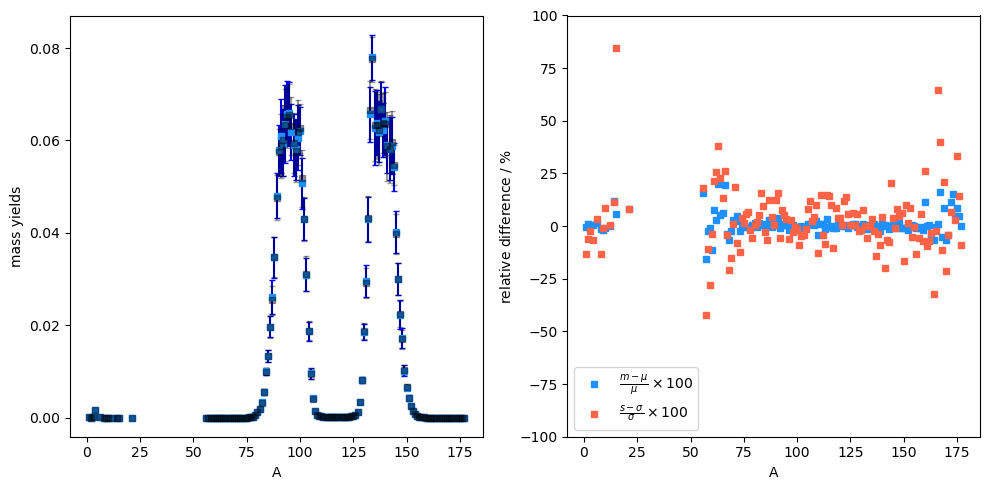

In [28]:
e = energies[0]

mask = f"MT==454 and E=={e}"
ify = nfpy.data.query(mask)
S = sandy.Fy(ify).get_mass_yield_sensitivity()
C = pd.DataFrame(acovs[e].data.values, index=ify.ZAP.values, columns=ify.ZAP.values)
cov_mfy = sandy.CategoryCov(S @ C @ S.T)

mu = nfpy.get_mass_yield(zam=922350, e=e)
sigma = cov_mfy.get_std()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax = axs[0]
ax.errorbar(x=mfy_th.index, y=mfy_th.T.mean(), yerr=mfy_th.T.std(), marker="s", ms=4, linestyle="none", capsize=2, ecolor="blue", color="dodgerblue", label="sample estimate")
ax.errorbar(x=mu.index, y=mu.values, yerr=sigma.values, marker="s", ms=4, linestyle="none", capsize=2, ecolor="k", color="k", alpha=.4, label="original data")
ax.set(ylabel="mass yields", xlabel="A")

ax = axs[1]
diff_mean = (mfy_th.T.mean() / mu  - 1) * 100
diff_std = (mfy_th.T.std() / sigma - 1) * 100
ax.errorbar(x=diff_mean.index, y=diff_mean.values, marker="s", ms=4, linestyle="none", color="dodgerblue", label="$\\frac{m- \\mu}{\\mu} \\times 100$")
ax.errorbar(x=diff_std.index, y=diff_std.values, marker="s", ms=4, linestyle="none", color="tomato", label="$\\frac{s- \\sigma}{\\sigma} \\times 100$")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="A")
ax.legend()
fig.tight_layout()

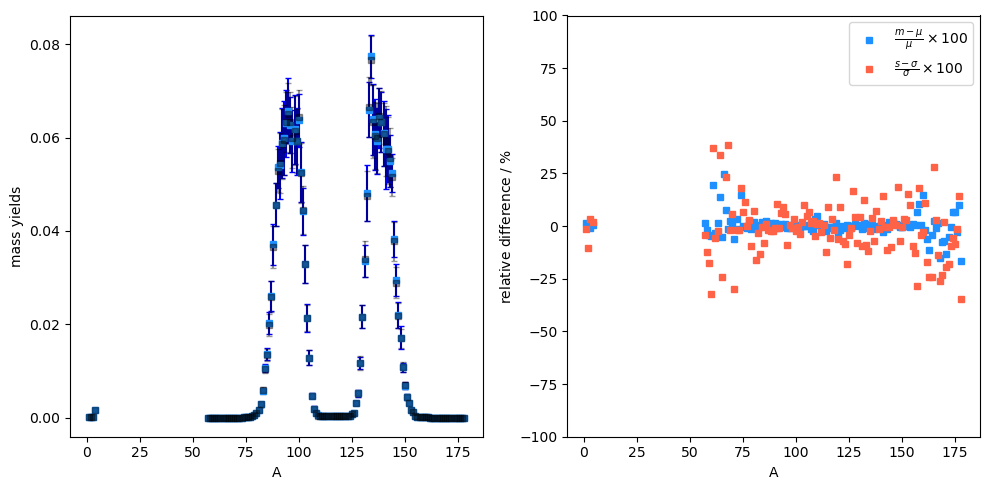

In [29]:
e = energies[1]

mask = f"MT==454 and E=={e}"
ify = nfpy.data.query(mask)
S = sandy.Fy(ify).get_mass_yield_sensitivity()
C = pd.DataFrame(acovs[e].data.values, index=ify.ZAP.values, columns=ify.ZAP.values)
cov_mfy = sandy.CategoryCov(S @ C @ S.T)

mu = nfpy.get_mass_yield(zam=922350, e=e)
sigma = cov_mfy.get_std()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax = axs[0]
ax.errorbar(x=mfy_fast.index, y=mfy_fast.T.mean(), yerr=mfy_fast.T.std(), marker="s", ms=4, linestyle="none", capsize=2, ecolor="blue", color="dodgerblue", label="sample estimate")
ax.errorbar(x=mu.index, y=mu.values, yerr=sigma.values, marker="s", ms=4, linestyle="none", capsize=2, ecolor="k", color="k", alpha=.4, label="original data")
ax.set(ylabel="mass yields", xlabel="A")

ax = axs[1]
diff_mean = (mfy_fast.T.mean() / mu  - 1) * 100
diff_std = (mfy_fast.T.std() / sigma - 1) * 100
ax.errorbar(x=diff_mean.index, y=diff_mean.values, marker="s", ms=4, linestyle="none", color="dodgerblue", label="$\\frac{m- \\mu}{\\mu} \\times 100$")
ax.errorbar(x=diff_std.index, y=diff_std.values, marker="s", ms=4, linestyle="none", color="tomato", label="$\\frac{s- \\sigma}{\\sigma} \\times 100$")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="A")
ax.legend()
fig.tight_layout()

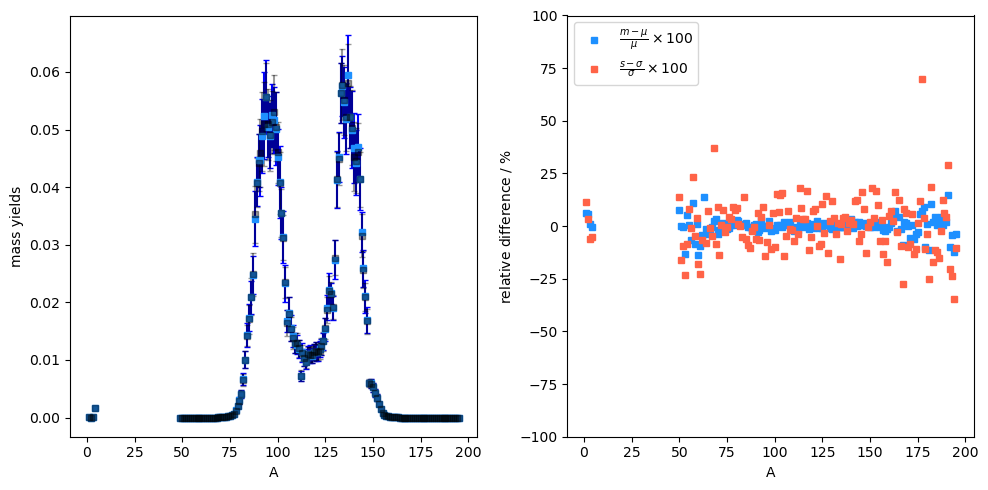

In [30]:
e = energies[2]

mask = f"MT==454 and E=={e}"
ify = nfpy.data.query(mask)
S = sandy.Fy(ify).get_mass_yield_sensitivity()
C = pd.DataFrame(acovs[e].data.values, index=ify.ZAP.values, columns=ify.ZAP.values)
cov_mfy = sandy.CategoryCov(S @ C @ S.T)

mu = nfpy.get_mass_yield(zam=922350, e=e)
sigma = cov_mfy.get_std()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax = axs[0]
ax.errorbar(x=mfy_he.index, y=mfy_he.T.mean(), yerr=mfy_he.T.std(), marker="s", ms=4, linestyle="none", capsize=2, ecolor="blue", color="dodgerblue", label="sample estimate")
ax.errorbar(x=mu.index, y=mu.values, yerr=sigma.values, marker="s", ms=4, linestyle="none", capsize=2, ecolor="k", color="k", alpha=.4, label="original data")
ax.set(ylabel="mass yields", xlabel="A")

ax = axs[1]
diff_mean = (mfy_he.T.mean() / mu  - 1) * 100
diff_std = (mfy_he.T.std() / sigma - 1) * 100
ax.errorbar(x=diff_mean.index, y=diff_mean.values, marker="s", ms=4, linestyle="none", color="dodgerblue", label="$\\frac{m- \\mu}{\\mu} \\times 100$")
ax.errorbar(x=diff_std.index, y=diff_std.values, marker="s", ms=4, linestyle="none", color="tomato", label="$\\frac{s- \\sigma}{\\sigma} \\times 100$")
ax.set(ylim=[-100, 100], ylabel="relative difference / $\\%$", xlabel="A")
ax.legend()
fig.tight_layout()